# Lab 3

In [111]:
FIRST_NAME = "Leng"
LAST_NAME = "Her"
STUDENT_ID = "5445877"

## Introduction

In this lab, we will rework some of the machine learning tasks from Lab 2 to use k-fold cross validation and the Scikit Learn Pipelines framework. Then we will log the cross validation results to ML Flow.

## The Data Set

**Data Description**

This is a simulated data set of students performance in the INET 4062 class. _None of these are actual students._

**Data Dictionary**

| Column Name | Type | Description |
| :----------- | :-- | :----------- |
| studentId | `int` | Unique Id of student |
| gpa | `float` | Current cumulative GPA |
| labHours | `float` | Number of hours spent per week on labs |
| studyHours | `float` | Number of hours spent studying for each exam |
| took4061 | `int` | Binary if student took INET 4061 (0=No, 1=Yes) |
| pythonExp | `int` | A High, Medium, or Low rating from student on previous python experience (0=Low, 1=Medium, 2=High) |
| statsRating | `int` | A 0-5 rating of ability on statistics |
| height | `float` | Height of student in inches |
| eyeColor | `str` | Eye color of student |
| followers | `int` | Number of followers on all social media accounts |
| grade | `float` | Percentage grade in INET 4062 out of 100 |
| letterGrade | `str` | Letter grade derived from the percentage |


**Data Sample**

|   studentId |     gpa |   labHours |   studyHours |   took4061 |   pythonExp |   statsRating |   height | eyeColor   |   followers |   grade | letterGrade   |
|------------:|--------:|-----------:|-------------:|-----------:|------------:|--------------:|---------:|:-----------|------------:|--------:|:--------------|
|           0 | 3.62061 |   3.0089   |     4.36066  |          1 |           2 |             3 |  69.4933 | brown      |         632 |   92.31 | A-            |
|           1 | 3.19391 |   2.524    |     4.88687  |          0 |           2 |             2 |  67.3275 | blue       |          44 |   85.59 | B             |
|           2 | 3.19453 |   0.903686 |     2.0478   |          1 |           1 |             5 |  69.3401 | green      |         181 |   88.39 | B+            |
|           3 | 3.27793 |   4.88015  |     0.822806 |          1 |           2 |             4 |  67.8951 | blue       |         347 |   90.91 | A-            |
|           4 | 2.5     |   1.47281  |     7.51036  |          0 |           2 |             4 |  67.708  | brown      |        1070 |   84.14 | B             |
|           5 | 2.56162 |   4.53166  |     5.50934  |          0 |           1 |             5 |  69.6897 | hazel      |          18 |   84.37 | B             |
|           6 | 3.15581 |   2.60646  |     1.56167  |          0 |           1 |             5 |  69.045  | hazel      |        7007 |   84.2  | B             |
|           7 | 3.73405 |   2.41052  |     2.99812  |          1 |           2 |             5 |  66.5794 | brown      |        5599 |   93.6  | A             |
|           8 | 2.98454 |   2.68131  |     1.73898  |          1 |           2 |             4 |  69.1432 | hazel      |        1206 |   88.73 | B+            |
|           9 | 3.84509 |   5.43147  |     4.9316   |          1 |           1 |             1 |  68.034  | blue       |       40097 |   92.12 | A-            |

#### Simulate Data

In [112]:
import numpy as np
import pandas as pd

n = 10000 # number of records to simulate
np.random.seed(40) # set the seed of the random number generator

# Current GPA
gpa = 0.4 * np.random.randn(n) + 3.25
gpa = np.clip(gpa, 2.5, 4.0)

# Average hours per week on Labs
labHours = 5.5/np.exp(2*np.random.rand(n))

# Number of hours studying for exam
studyHours = np.power(2*np.random.rand(n) + 0.75, 2)

# Junior or Senior
isSenior = np.random.binomial(size=n, n=1, p=0.67)

# Took 4061
took4061 = np.random.binomial(size=n, n=1, p=0.75)

# Previous Python Experience
pythonExp = np.random.binomial(size=n, n=2, p=0.70)

# Ability in statistics
statsRating = np.random.binomial(size=n, n=5, p=0.75)

# Height
height = 4 * np.random.rand(n) + 66.5

# Eye Color
eyeColor = np.random.choice(["blue", "green", "brown", "hazel"], n)

# Social media followers
followers = (10 ** (1+5*np.random.beta(3, 7, size=n))).round()

# simulate grades
grade = 72 + (((gpa**2)/3 + np.sqrt(statsRating+1)) * 
              np.sqrt(labHours/3 + studyHours/6 + pythonExp + 3*took4061)) + \
              (1+3*np.random.rand())

# Compile columns into a DataFrame
students_df = pd.DataFrame({
    'gpa' : gpa,
    'labHours' : labHours,
    'studyHours' : studyHours,
    'took4061' : took4061,
    'pythonExp' : pythonExp,
    'statsRating' : statsRating,
    'height' : height,
    'eyeColor' : eyeColor,
    'followers' : followers,
    'grade' : grade.round(2)
})

# Define a function to calculate the letter grade based
# on the percentage in the class
def getLetterGrade(x):
  if x < 76.67:
    return("C")
  elif x < 80:
    return("C+")
  elif x < 83.33:
    return("B-")
  elif x < 86.67:
    return("B")
  elif x < 90:
    return("B+")
  elif x < 93.33:
    return("A-")
  else:
    return("A")

# Add the letter grade column to the DataFrame
students_df['letterGrade'] = students_df['grade'].apply(lambda row: getLetterGrade(row))

# Rename the index of the DataFrame to be `studentId`
# because that index uniquely identifies 1 student
students_df.index.rename("studentId", inplace=True)
students_df.reset_index(drop=False, inplace=True)

In [113]:
students_df

,studentId,gpa,labHours,studyHours,took4061,pythonExp,statsRating,height,eyeColor,followers,grade,letterGrade
0,0,3.006981,4.312076,6.154981,1,1,4,68.968833,hazel,150.0,88.10,B+
1,1,3.199545,4.468924,6.607994,1,1,3,68.210087,hazel,499.0,88.65,B+
2,2,2.976157,2.074952,1.599081,1,2,5,69.524292,green,117.0,87.94,B+
3,3,3.621486,0.994602,7.210698,1,2,5,70.242933,brown,1049.0,92.19,A-
4,4,2.512240,0.819105,2.258261,1,1,1,66.546452,brown,72.0,82.34,B-
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,3.265625,0.915808,7.422218,1,2,5,68.925192,hazel,149.0,90.12,A-
9996,9996,3.197060,2.061146,4.550661,1,2,4,67.969562,green,863.0,89.08,B+
9997,9997,2.513514,2.893784,3.403938,1,2,4,67.587846,green,334.0,85.85,B
9998,9998,3.115089,3.472824,6.973135,1,2,3,67.842580,green,266.0,88.92,B+


## Question 1




Define a Scikit-Learn [ColumnTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html) do the data preprocessing steps before building machine learning models. Save this to a variable named `preprocessor`. 

It must do the following 2 steps:
 * Scale 3 numeric features _(gpa, labHours, studyHours)_ to have values between 0-1 with [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).
 * One hot encode 3 categorical features _(took4061, pythonExp, statsRating)_ using [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

### Resources

* Scikit Learn User Guides: [ColumnTransformer](https://scikit-learn.org/stable/modules/compose.html#column-transformer), [MinMaxScaler](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler), [OneHotEncoder](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features)
* Class examples: [ML Pipelines Notebook](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features), [ML Flow Example Notebook](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features)
* Other examples: [Analytics Vidhya](https://www.analyticsvidhya.com/blog/2021/05/understanding-column-transformer-and-machine-learning-pipelines/), [UBC SPSC 330 Notes](https://ubc-cs.github.io/cpsc330/lectures/06_column-transformer-text-feats.html#create-a-column-transformer), [Medium - MLearning.ai](https://medium.com/mlearning-ai/neat-data-preprocessing-with-pipeline-and-columntransformer-2a0468865b6b)

### Answer

In [114]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [115]:
encoder = OneHotEncoder()

# define numeric and categorical feature columns
numeric_cols = ['gpa', 'labHours', 'studyHours']
categorical_cols = ['took4061', 'pythonExp', 'statsRating']

# create the transformer
preprocessor = ColumnTransformer(transformers=[
        ('num', MinMaxScaler(), numeric_cols),
        ('cat', encoder, categorical_cols)])


In [116]:
preprocessor

ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                 ['gpa', 'labHours', 'studyHours']),
                                ('cat', OneHotEncoder(),
                                 ['took4061', 'pythonExp', 'statsRating'])])

## Question 2

Define Scikit-Learn Pipeline objects for 3 Regression alforithms:
 * [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) - name this variable `lm_pipeline` for _"linear model"_
 * [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) - name this variable `knn_pipeline` for _"k nearest neighbor"_
 * [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) - name this variable `rf_pipeline` for _"random forest"_

Each pipeline should have 2 steps:
 1. The `preprocessor` from Question 1
 2. A regression algorithm mentioned above

### Resources

* Scikit Learn User Guides: [Lasso](https://scikit-learn.org/stable/modules/linear_model.html#lasso), [KNN Regression](https://scikit-learn.org/stable/modules/neighbors.html#regression), [Random Forest](https://scikit-learn.org/stable/modules/ensemble.html#forest)
* Class examples: [ML Pipelines Notebook](https://scikit-learn.org/stable/modules/neighbors.html#regression), [ML Flow Example Notebook](https://scikit-learn.org/stable/modules/neighbors.html#regression)
* Other exmaples: [Machine Learning Mastery](https://machinelearningmastery.com/modeling-pipeline-optimization-with-scikit-learn/), [UBC SPSC 330 Notes](https://ubc-cs.github.io/cpsc330/lectures/05_preprocessing-pipelines.html#pipelines), [Medium - MLearning.ai](https://medium.com/mlearning-ai/neat-data-preprocessing-with-pipeline-and-columntransformer-2a0468865b6b) (same article as Q1))

### Answer

In [117]:
from sklearn.pipeline import Pipeline

from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

In [118]:

# Define the pipelines
lm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', Lasso())])

In [119]:
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', KNeighborsRegressor())])

In [120]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', RandomForestRegressor())])

## Question 3

Define Python dictionaries to hold the hyperparameters for each ML algroithm. These dictionaries will be used by Scikit-Learn's [ParameterGrid](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html) to do a full grid search of all combinations of hyperparameters.

The names of the dictionaries and the hyperparameters to search through for each algorithm should be as follows:

**Lasso**     
`lm_params`
* _alpha : [0.05, 0.10, 0.25, 0.50, 0.75, 1]_

**K nearest neighbors**     
`knn_params`
* _n\_neighbors : [5, 10, 20]_
* _weights : ["uniform", "distance"]_

**Random Forest**     
`rf_params`
* _n\_estimators : [25, 100]_
* _max\_depth : [3, 10]_

### Resources

Note: Because the we are running these algroithms from within a Scikit-Learn pipeline, we need to _prefix the hyperparameter names with the name of the pipeline step and 2 underscores_ that runs the algorithm. 

For example, if were going to run a grid search over the following parameters for a Support Vector Regression (SVR):
```
svr_params = {
    'C' : [1, 2, 3],   kernel' : ["linear", "rbf"]
}
```

And we were running the [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) in the following pipeline:
```
svr_pipeline = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("the_SVR_step", SVR())
    ]
)
```

Then we would define the parameter grid dictionary as follows:
```
svr_params = {
    'the_SVR_step__C' : [1, 2, 3],
    'the_SVR_step__kernel' : ["linear", "rbf"]
}
```

Class Examples:
* [ML Pipelines Notebook](https://colab.research.google.com/drive/1ckqcFT1prkeEoHJy-5mgpLWJIQ-TL_n3#scrollTo=7zsfrzaDHaZu)
* [ML Flow Example Notebook](https://colab.research.google.com/drive/1oimnZe_AWwvwqXWfw1wsR5Juh5WEVSqH#scrollTo=gi-_kicg3uTl)

### Answer

In [121]:
lm_params = {
    'regressor__alpha': [0.05, 0.10, 0.25, 0.50, 0.75, 1]
}


In [122]:
knn_params = {
    'regressor__n_neighbors': [5, 10, 20],
    'regressor__weights': ["uniform", "distance"]
}

In [123]:
rf_params = {
    'regressor__n_estimators': [25, 100],
    'regressor__max_depth': [3, 10]
}


## Question 4

**Part a**    
Split the `students_df` data frame into 2 parts,`X` and `y`.
* `X` - contains only the feature columns of the data frame that are used in preprocessor.
* `y` contains only the label columns "grade"

**Part b**      
Then do a train/test split on the `X` and `y` datasets where 75% of the rows are in the train set, and 25% are in the test set. Set the random seed to `4062` for the train/test split.

_Note: Parts a & b are the same as Question 1 from Lab 2_


**Part C**    
Define 3 [GridSeachCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) objects, 1 for each algorithm.
* The `estimator`for each GridSearchCV is the corresponding `**_pipeline` object containing the ML algorithm from Question 2.
* The `param_grid` for each GridSearchCV is the corresponding `**_params` dictionary from Question 3.
* The `scoring` parameter for each GridSearchCV should be set to _"r2"_


**Part D**    
Fit the GridSeachCV objects to the training data (`X_train`, `y_train`) using the `.fit()` method.

### Resources

* Scikit Learn User Guides: [train_test_split](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation), [GridSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#grid-search)
* Class examples: [ML Pipelines Notebook](https://colab.research.google.com/drive/1ckqcFT1prkeEoHJy-5mgpLWJIQ-TL_n3#scrollTo=7zsfrzaDHaZu), [ML Flow Example Notebook](https://colab.research.google.com/drive/1oimnZe_AWwvwqXWfw1wsR5Juh5WEVSqH#scrollTo=xY9fb3ZxrqbI&line=3&uniqifier=1)
* Other examples: ⭐ [Python Simplifed](https://pythonsimplified.com/how-to-use-k-fold-cv-and-gridsearchcv-with-sklearn-pipeline/) (gold star means highly recommended example)

### Answer

In [124]:
from sklearn.model_selection import GridSearchCV, train_test_split

In [125]:
#Part A
X = students_df[['gpa', 'labHours', 'studyHours', 'took4061', 'pythonExp', 'statsRating']]
y = students_df['grade']


In [126]:
#Part B
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4062)
#Part C
lm_grid = GridSearchCV(lm_pipeline, lm_params, scoring='r2')
knn_grid = GridSearchCV(knn_pipeline, knn_params, scoring='r2')
rf_grid = GridSearchCV(rf_pipeline, rf_params, scoring='r2')

In [127]:
#Part D
lm_grid.fit(X_train, y_train)
knn_grid.fit(X_train, y_train)
rf_grid.fit(X_train, y_train)


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['gpa',
                                                                          'labHours',
                                                                          'studyHours']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['took4061',
                                                                          'pythonExp',
                                                                          'statsRating'])])),
                                       ('regressor', RandomForestRegressor())]),


## Question 5

Create 3 ML flow experiments called "Lasso", "KNN", and "Random Forest".

For each of these experiments, log the grid search cross validation results from the associated algorithm. The full results for each set of parameters can be found in the `.cv_results_` attribute of the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) objects.

Each run should:
* Log the hyperparameters for the model with `mlflow.log_param()`.
* Log the `mean_test_score` of all the folds with `mlflow.log_metric()`. Name the metric _"r2"_
* Set a tag for the run as _"algorithm"_ using `mlflow.set_tag()`. The value be the corresponding Scikit Learn model object used: _Lasso, KNeighborsRegressor, or RandomForestRegressor._

After logging, you should be able to click the link for the ML Flow UI below and see all the experiment results. It should look similar to this.

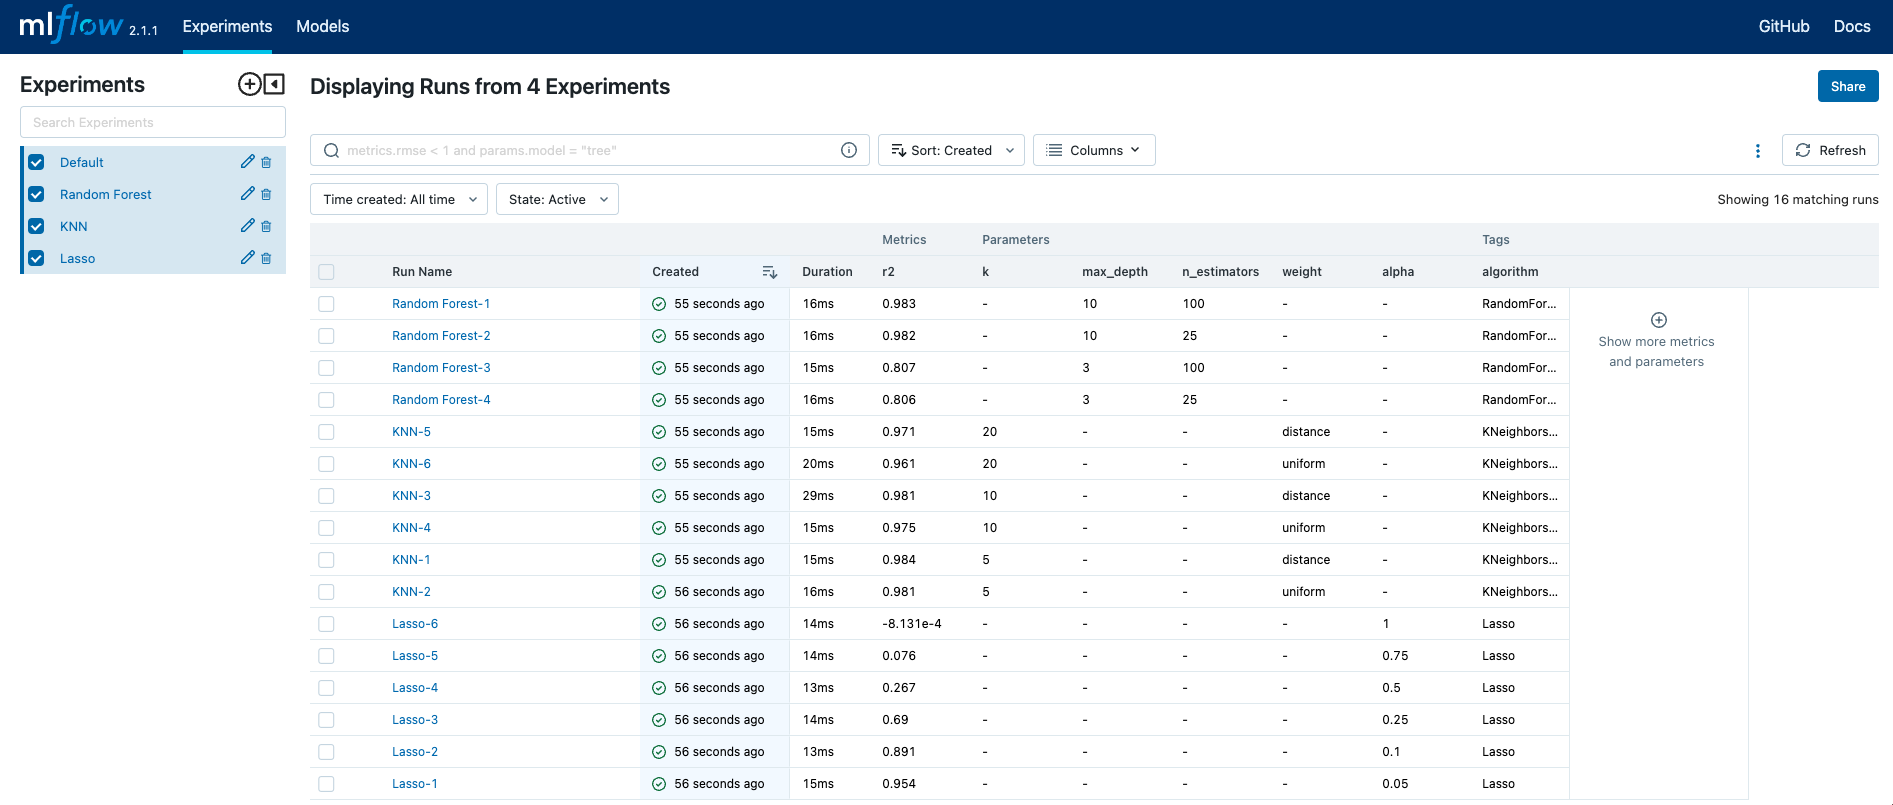

### Resources

* ML Flow Python API Documentation: [log_param](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.log_param), [log_metric](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.log_metric), [set_tag](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.set_tag)
* Class example: [ML Flow Example Notebook](https://colab.research.google.com/drive/1oimnZe_AWwvwqXWfw1wsR5Juh5WEVSqH#scrollTo=X9-pmlXW1u8i&line=2&uniqifier=1)
* Other example: [MLflow Sklearn Example GitHub](https://github.com/mlflow/mlflow/blob/master/examples/sklearn_elasticnet_wine/train.py)

### ML Flow Setup

In [128]:
# Install the mlflow python package
%pip install mlflow --quiet

In [129]:
import mlflow

In [130]:
# Run the UI as a background process
get_ipython().system_raw("mlflow ui --port 5000 &")

In [131]:
# Print out the URL to access the port the UI is running on
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://pl14v99h89-496ff2e9c6d22116-5000-colab.googleusercontent.com/


Note: Couldn't get link to work even trying different ports, so I ran it on local machine to access MLflow. Ended up working easier

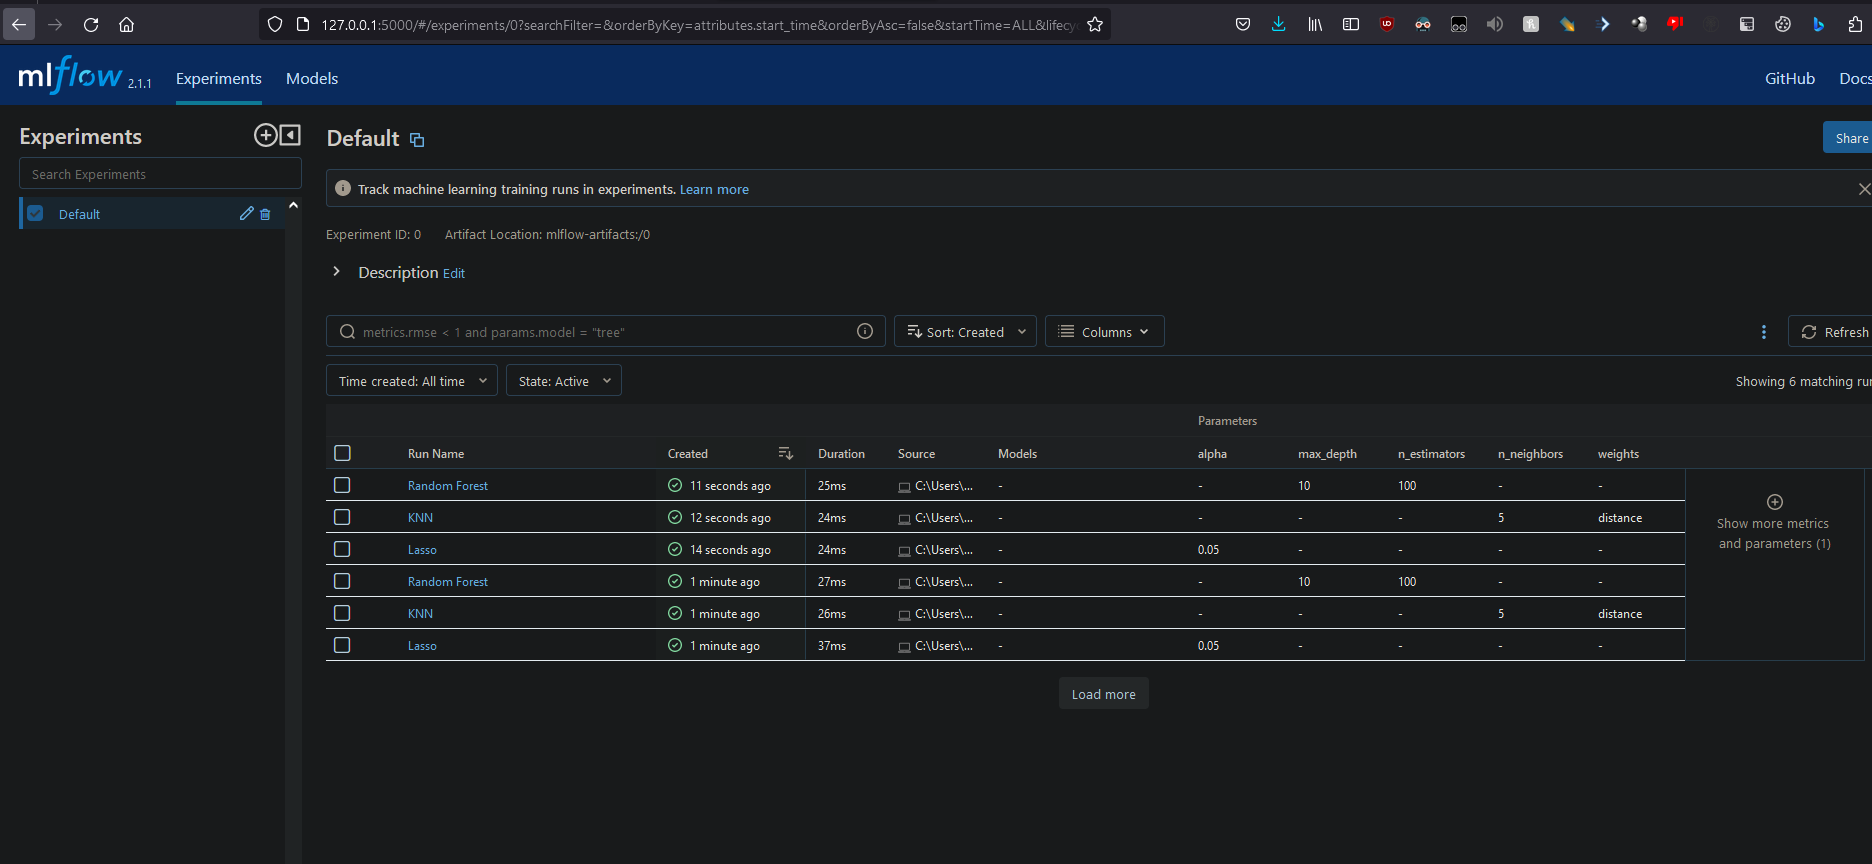

### Answer

In [132]:
# create the three experiments
with mlflow.start_run(run_name="Lasso") as run:
    mlflow.log_param("alpha", lm_grid.best_params_['regressor__alpha'])
    mlflow.log_metric("r2", lm_grid.best_score_)
    mlflow.set_tag("algorithm", "Lasso")

In [133]:
with mlflow.start_run(run_name="KNN") as run:
    mlflow.log_param("n_neighbors", knn_grid.best_params_['regressor__n_neighbors'])
    mlflow.log_param("weights", knn_grid.best_params_['regressor__weights'])
    mlflow.log_metric("r2", knn_grid.best_score_)
    mlflow.set_tag("algorithm", "KNeighborsRegressor")

In [134]:
with mlflow.start_run(run_name="Random Forest") as run:
    mlflow.log_param("n_estimators", rf_grid.best_params_['regressor__n_estimators'])
    mlflow.log_param("max_depth", rf_grid.best_params_['regressor__max_depth'])
    mlflow.log_metric("r2", rf_grid.best_score_)
    mlflow.set_tag("algorithm", "RandomForestRegressor")

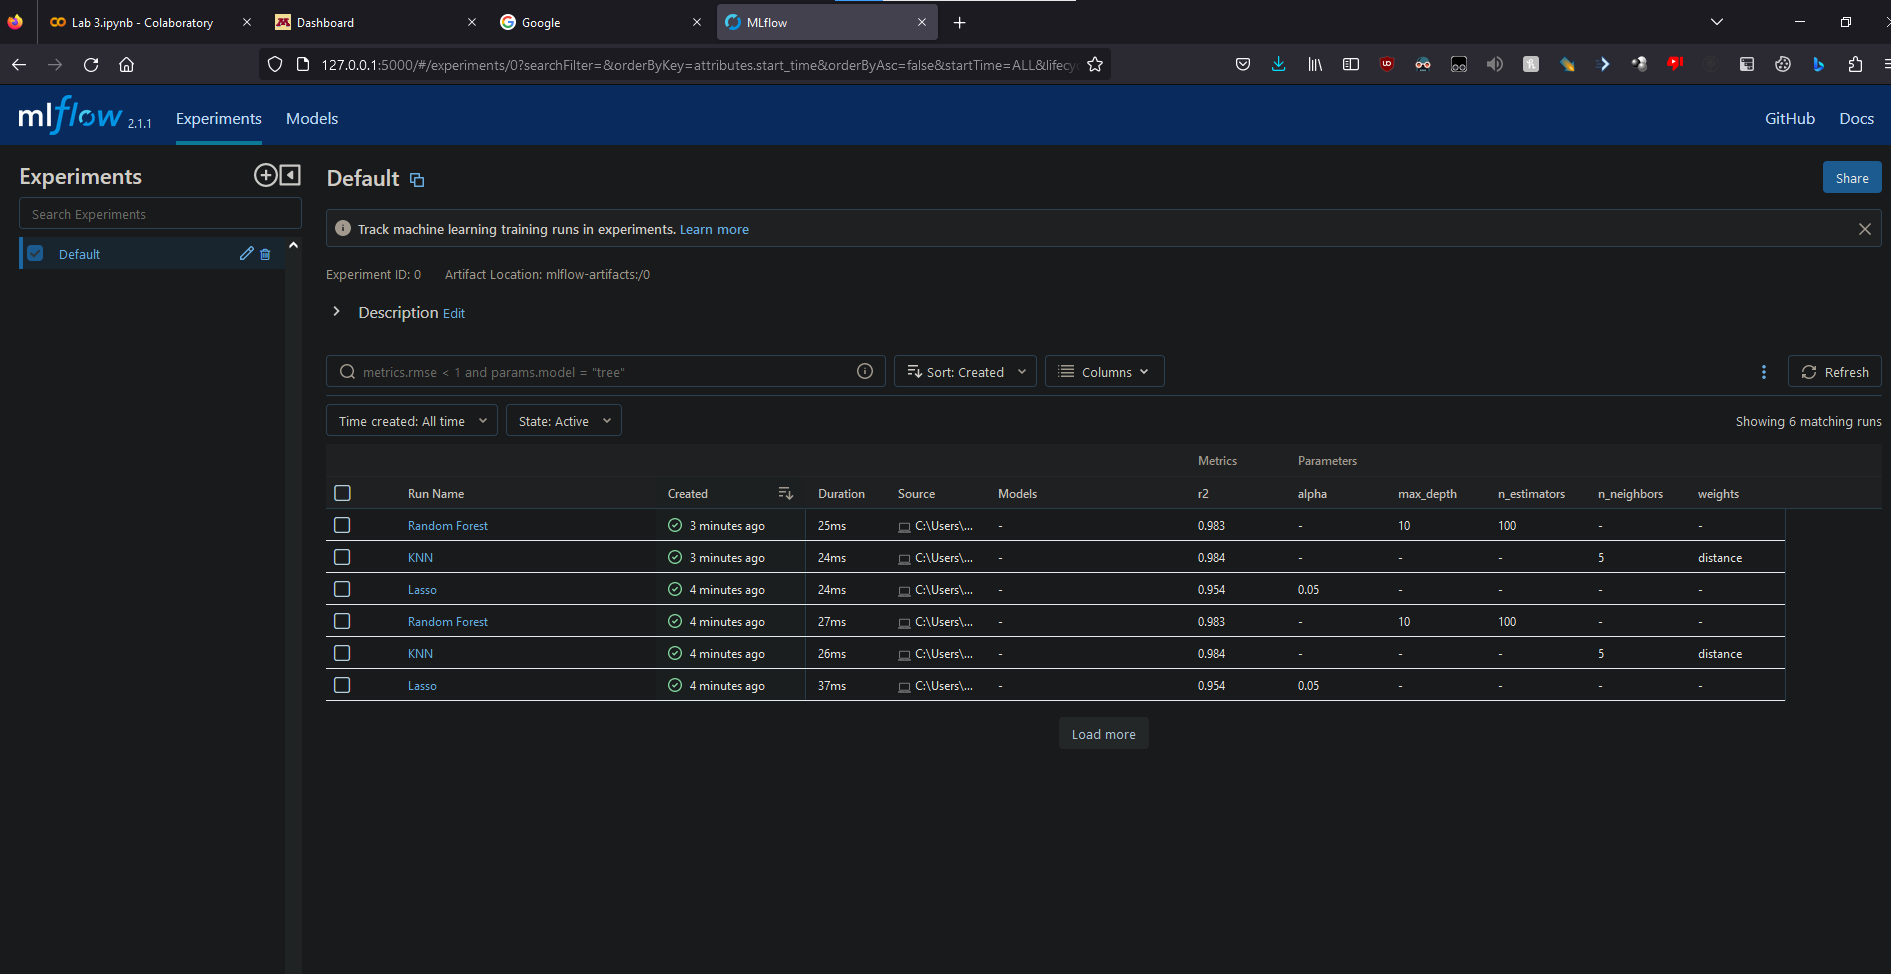

Heres some attributes shown with 2 runtimes of each model